ALL NEEDED IMPORTS

In [163]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
from pmdarima.arima import auto_arima
# %matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tfa

import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

DATA PREPROCESSING  

In [164]:
data = pd.read_excel('Natural_Gas_Spot_Price.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505 entries, 0 to 6504
Data columns (total 2 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date                                                        6505 non-null   datetime64[ns]
 1   Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  6504 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 101.8 KB


In [165]:
data = data.rename(
    columns={
        "Henry Hub Natural Gas Spot Price (Dollars per Million Btu)":"gas_price",
        "Date":"date"
    }
)

In [166]:
data = data.fillna(method = 'pad')
print(data.isnull().sum())

date         0
gas_price    0
dtype: int64


In [167]:
data['date'] = pd.to_datetime(data['date'], format = "%d/%m/%Y")

In [168]:
data = data.set_index('date')

TESTING THE DATASET'S STATIONARITY

In [169]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(data, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
        
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -4.027811
p-value                           0.001272
#Lags Used                        7.000000
Number of Observations Used    6497.000000
Critical Value (1%)              -3.431357
Critical Value (5%)              -2.861985
Critical Value (10%)             -2.567007
dtype: float64


SPLITTING THE DATASET

In [170]:
data = data.sort_values(by = 'date')

train = data['1997-01-06': '2012-08-14'] # 7 Jan 1997 to 6 Jan 2021 
test = data['2012-08-14': '2022-11-15'] # 7 Jan 2021  to 1 Mar 2022 

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test)) 

Length of Train Data:  3905
Length of Test Data:  2601


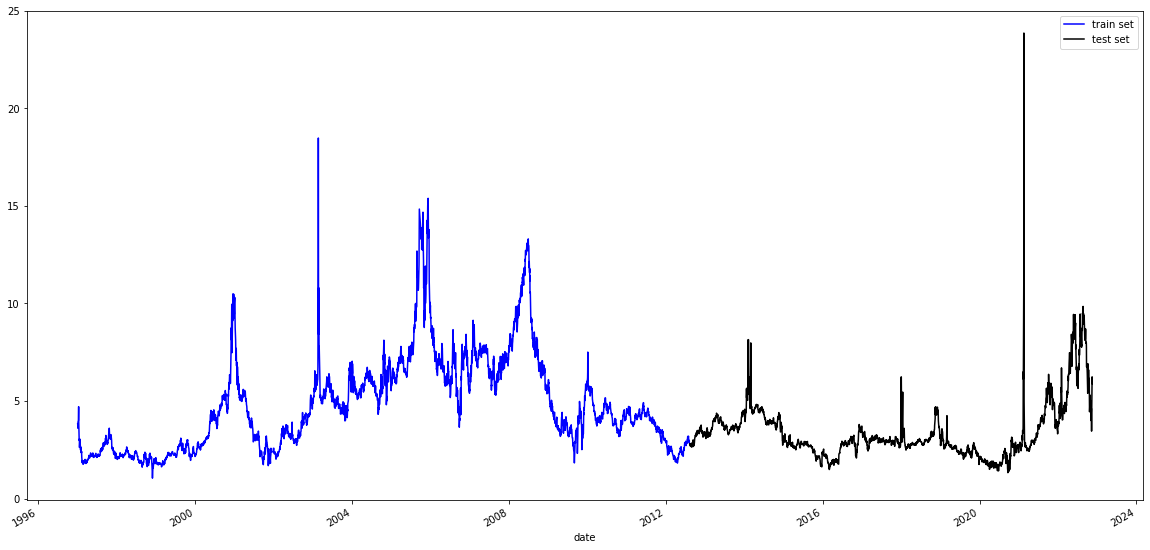

In [171]:
ax = train.plot(figsize = (20, 10), color = 'b')
test.plot(ax = ax, color = 'black')
plt.legend(['train set', 'test set'])
plt.show()

PICKING BEST PARAMETERS FOR MODEL

In [172]:
model = auto_arima(data, start_p=0, start_q=0, max_p=10, max_q=10, m=12, seasonal=False, trace=True)
# The seasonal parameter is set to False to indicate that the data has no seasonal component, 
# and the m parameter is set to 12 to indicate that the data has a seasonal period of 12 months (i.e., monthly data). 
# The stepwise parameter is set to True to enable the stepwise search algorithm, 
# which is more computationally efficient than a grid search over all possible model orders. 
# The trace parameter is set to True to print the progress of the search algorithm as it fits and evaluates different models.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5738.391, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5704.269, Time=1.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5677.015, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5736.396, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5433.032, Time=2.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5365.263, Time=2.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5388.125, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5315.483, Time=5.96 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5388.712, Time=0.95 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5289.127, Time=10.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=5328.772, Time=0.98 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=5290.906, Time=5.99 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=12.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5288.083, Time=9.98 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   

In [173]:
seasonal_order = model.seasonal_order
print(seasonal_order)
order = model.order
print(order)

(0, 0, 0, 0)
(3, 1, 2)


INITIALIZING AND FITTING THE MODEL

In [174]:
sarima_model = SARIMAX(data, order=(3,1,2), seasonal_order=seasonal_order)
result = sarima_model.fit()


print(result.summary())
print('AIC:', result.aic)
print('BIC:', result.bic)
print('RMSE:', np.sqrt(np.mean((result.resid.values)**2)))


                               SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                 6505
Model:               SARIMAX(3, 2, 2)   Log Likelihood               -2694.574
Date:                Wed, 29 Mar 2023   AIC                           5401.148
Time:                        21:48:09   BIC                           5441.828
Sample:                             0   HQIC                          5415.218
                               - 6505                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0677      0.080    -13.326      0.000      -1.225      -0.911
ar.L2         -0.3068      0.008    -38.259      0.000      -0.323      -0.291
ar.L3         -0.2115      0.019    -11.011      0.0

MAKE THE PREDICTIONS

In [175]:
yp_train = result.predict(start = 0, end = (len(train)-1))
yp_test = result.predict(start='2012-08-14', end='2022-11-15') 

print("Train Data:\nMean Square Error: {}".format(mean_squared_error(train, yp_train)))
print("\nTest Data:\nMean Square Error: {}".format(mean_squared_error(test, yp_test)))

Train Data:
Mean Square Error: 0.09183214785992944

Test Data:
Mean Square Error: 0.20421383701620188


VISUALIZE PREDICTION AGAINST ACTUAL

In [176]:
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'SARIMA_pred'}, inplace = True)

# a.index = train.iloc[slot:].index
train_compare = pd.concat([train, a], 1)
train_compare

,gas_price,predicted_mean
date,,
1997-01-07,3.82,0.000000
1997-01-08,3.80,5.730000
1997-01-09,3.61,3.780001
1997-01-10,3.92,3.494115
1997-01-13,4.00,3.990091
...,...,...
2012-08-08,2.97,2.984617
2012-08-09,2.89,2.950675
2012-08-10,2.84,2.902276


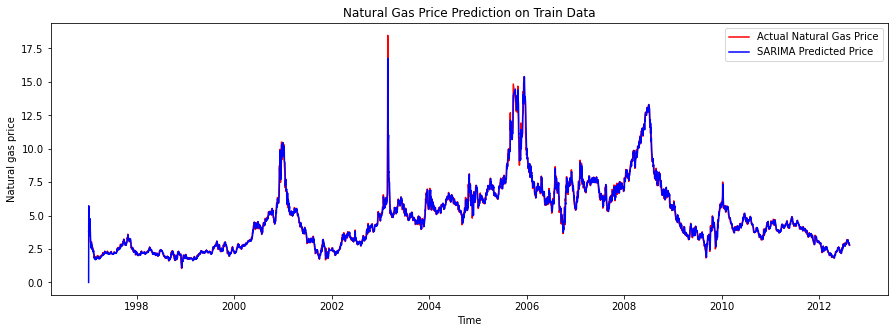

In [177]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['predicted_mean'], color = 'blue', label = 'SARIMA Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [178]:
b = pd.DataFrame(yp_test)
a.rename(columns = {0: 'SARIMA_pred'}, inplace = True)

# a.index = train.iloc[slot:].index
test_compare = pd.concat([test, b], 1)
test_compare

,gas_price,predicted_mean
date,,
2012-08-14,2.79,2.787696
2012-08-15,2.82,2.801936
2012-08-16,2.78,2.813291
2012-08-17,2.70,2.775704
2012-08-20,2.75,2.716271
...,...,...
2022-11-09,3.46,3.919250
2022-11-10,4.80,3.646564
2022-11-11,4.80,4.794069


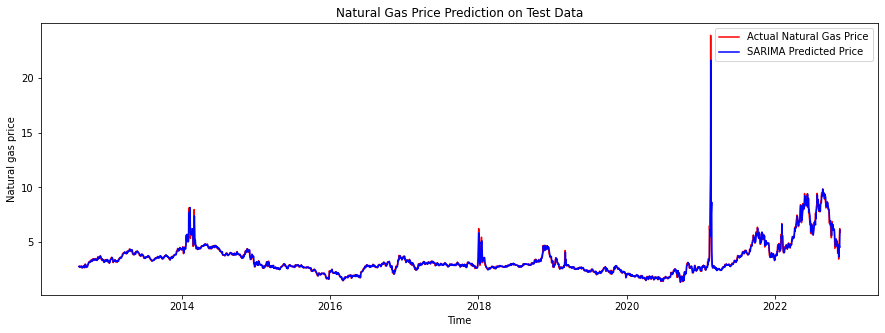

In [179]:
plt.figure(figsize = (15, 5))
# plt.plot(train,color = 'black',label = "train")
plt.plot(test_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['predicted_mean'], color = 'blue', label = 'SARIMA Predicted Price')
plt.title("Natural Gas Price Prediction on Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

EVALUATION TIME

In [180]:
mse_train = mean_squared_error(train_compare['gas_price'], train_compare['predicted_mean'])
mse_test = mean_squared_error(test_compare['gas_price'], test_compare['predicted_mean'])

r2_train = r2_score(train_compare['gas_price'], train_compare['predicted_mean'])
r2_test = r2_score(test_compare['gas_price'], test_compare['predicted_mean'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 0.09183214785992944
R Square: 0.9843748313096436

Test Data:
MSE: 0.20421383701620188
R Square: 0.9021183704947076


In [181]:
arima_mae = mean_absolute_error(test, yp_test)
arima_mse = mean_squared_error(test, yp_test)
arima_rmse = np.sqrt(arima_mse)

# print the performance metrics
print('SARIMA Performance Metrics:')
print('MAE:', arima_mae)
print('MSE:', arima_mse)
print('RMSE:', arima_rmse)
# print('MAPE:', arima_mape)

SARIMA Performance Metrics:
MAE: 0.12290075168876995
MSE: 0.20421383701620188
RMSE: 0.4519002511796181


In [182]:
mape = []
for index,row in test_compare.iterrows():
    # value = row[0]
    # print(value)
    a = np.mean(np.abs((row[0] - row[1]) / row[0])) * 100
    mape.append(a)
avg = sum(mape)/len(mape)
print('MAPE: %.2f%%' % avg)
# mape

MAPE: 3.18%


FORECASTING NEXT WEEK'S PRICES

In [183]:
pred_uc = result.get_forecast(steps=100,dynamic=False)
pred_ci = pred_uc.conf_int()

In [184]:
pred_values = pred_uc.predicted_mean
pred_values = pred_values.to_frame()

In [185]:
pred_values = pred_values.reset_index()

In [186]:
pred_values

,index,predicted_mean
0,6505,5.614921
1,6506,5.720055
2,6507,5.768260
3,6508,5.745901
4,6509,5.733803
...,...,...
95,6600,5.779646
96,6601,5.779676
97,6602,5.780457
98,6603,5.780505


In [187]:
dates = pd.date_range(start='2022-11-16', periods=100, freq='D')
dates = pd.DataFrame(dates)
# dates = dates.rename(columns={'0': 'date'})
dates['predicted_mean'] = pred_values['predicted_mean']
dates.columns.values[0] = 'date'
dates


,date,predicted_mean
0,2022-11-16,5.614921
1,2022-11-17,5.720055
2,2022-11-18,5.768260
3,2022-11-19,5.745901
4,2022-11-20,5.733803
...,...,...
95,2023-02-19,5.779646
96,2023-02-20,5.779676
97,2023-02-21,5.780457
98,2023-02-22,5.780505


In [188]:
data1 = pd.read_csv('forecast.csv')

data1 = data1.drop('predicted_mean', axis=1)

dates['date'] = pd.to_datetime(dates['date'])
data1['date'] = pd.to_datetime(data1['date'])


In [189]:
df_merged = pd.merge(data1, dates[['date', 'predicted_mean']], on='date', how='inner')
df_merged

,date,gas_price,predicted_mean
0,2022-11-16,5.88,5.614921
1,2022-11-17,6.20,5.720055
2,2022-11-18,6.10,5.768260
3,2022-11-21,6.23,5.744444
4,2022-11-22,6.27,5.742586
...,...,...,...
61,2023-02-15,2.45,5.778025
62,2023-02-16,2.48,5.778016
63,2023-02-17,2.28,5.778835
64,2023-02-21,2.12,5.780457


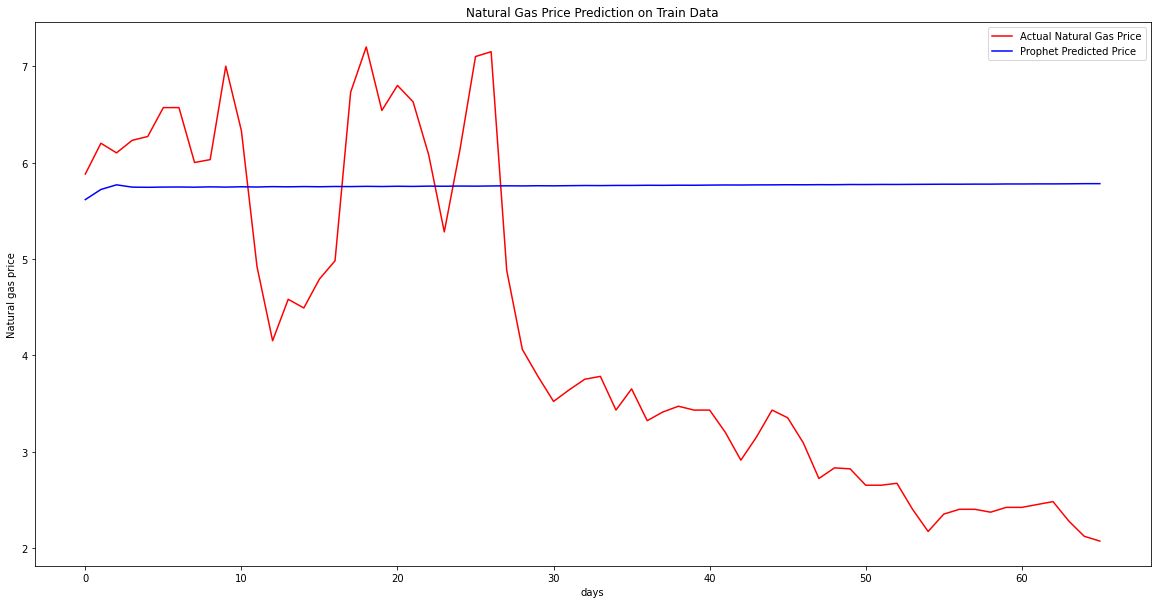

In [190]:
plt.figure(figsize = (20, 10))
plt.plot(df_merged['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(df_merged['predicted_mean'], color = 'blue', label = 'Prophet Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('days')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [191]:
mean_squared_error(df_merged['gas_price'], df_merged['predicted_mean'])

5.070678474597258